In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from iafCA import iafCA
import pygame

pygame 2.0.1 (SDL 2.0.14, Python 3.9.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] + 0.2
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] - 0.2
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), 7)
    
    return cdim_order

# Test

In [3]:
RADIUS=50
kernel_increment = 0.01
ca = iafCA(RADIUS=RADIUS).cuda() 

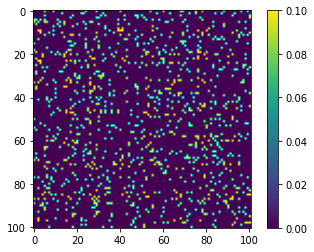

In [4]:
plt.imshow(ca.rule.nearest_neighbours.data[0, 0].cpu().numpy())
plt.colorbar()

In [5]:
# brush properties
r = 20
s = 1

### Init Webcam

In [6]:
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

# while True:
#     ret, frame = cap.read()
#     frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
#     cv2.imshow('Input', frame)

#     c = cv2.waitKey(1)
#     if c == 27:
#         break

# cap.release()
# cv2.destroyAllWindows()

In [7]:
ret, frame = cap.read()
frame = cv2.resize(frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [8]:
# resolution of grid
RESX=640
RESY=480

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 2
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

# webcam stuff
######################################
inject_webcam = False
wbcam_fx = RESX / frame.shape[1] * (frame.shape[0] / frame.shape[1])
wbcam_fy = RESY / frame.shape[0]

running = True
time_ticking = True
self_organize = False
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, 6)

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################

# CENTER SEED
# seed = torch.cuda.FloatTensor(np.zeros((CHANNELS, RESX, RESY))).unsqueeze(0)
# seed[:, 3:, RESX//2, RESY//2] = 1
# state = seed.clone()

state = ca.initGrid((RESX, RESY))

# inject noise
signal_injection = torch.zeros(size=state.shape)
noise_amp = 1.
noise_idx = slice(4, 10)

update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = -event.y
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -0.5
            if event.type== pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += 0.5
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                    
#             if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
#                 # pick another random CA
#                 ca = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, NET_SIZE=NET_SIZE, RADIUS=RADIUS).cuda() 
                
                
#             if event.type == pygame.VIDEORESIZE:
#                 print(event.w, event.h)
#                 surface = pygame.display.set_mode((event.w, event.h),
#                                               pygame.RESIZABLE)
            if event.type== pygame.KEYDOWN and event.key == pygame.K_k:
                ca.rule.nearest_neighbours = nn.Parameter(ca.rule.generate_cppn_kernel(), requires_grad=False)
            if event.type== pygame.KEYDOWN and event.key == pygame.K_UP:
                ca.rule.nearest_neighbours = ca.rule.nearest_neighbours + kernel_increment
            if event.type== pygame.KEYDOWN and event.key == pygame.K_DOWN:
                ca.rule.nearest_neighbours = ca.rule.nearest_neighbours - kernel_increment
            if event.type== pygame.KEYDOWN and event.key == pygame.K_w:
                inject_webcam = not inject_webcam
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_s:
                sink = not sink
            if event.type== pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type== pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid((RESX, RESY))
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
            
        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False
            
#         nx = state.cpu()[:, cdim_order].numpy()[0, 0, :, :].transpose(1, 2, 0)
        nx = state.cpu().numpy()[0, cdim_order[0], :, :]
#         nx = state.cpu()[0, cdim_order].numpy().transpose(1, 2, 0)
        nx = nx * 255.

        if time_ticking:
            state = ca.forward(state)
            ticker += 1
            
            if inject_webcam:
                ret, frame = cap.read()
                frame = cv2.resize(frame, None, fx=wbcam_fx, fy=wbcam_fy, interpolation=cv2.INTER_AREA)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).transpose()
                state[0, 1, 0:frame.shape[0], 0:frame.shape[1]] = state[0, 1, 0:frame.shape[0], 0:frame.shape[1]] + torch.cuda.FloatTensor(frame)/255. 
    
        if sink and time_ticking:
            xv, yv = torch.linspace(-1, 1, RESX), torch.linspace(-RESY/RESX, RESY/RESX, RESY)
            X, Y = torch.meshgrid(xv, yv)
            amp = 0.00
            w = 30
            R = torch.sqrt(X**2 + Y**2).cuda()
            state = torch.where(R > 0.5, state - 0.5 * torch.ones_like(state).cuda(), state)

        if export_imgs and time_ticking:
            imgs.append(nx)
        

        pygame.surfarray.blit_array(screen, nx)        
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        pygame.display.flip()
        clock.tick(60)
        
pygame.quit()


In [9]:
ret, frame = cap.read()
frame = cv2.resize(frame, None, fx=wbcam_fx, fy=wbcam_fy, interpolation=cv2.INTER_AREA)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).transpose()
frame.shape

(480, 480)

In [10]:
640/480

1.3333333333333333

Text(0.5, 1.0, 'Energy')

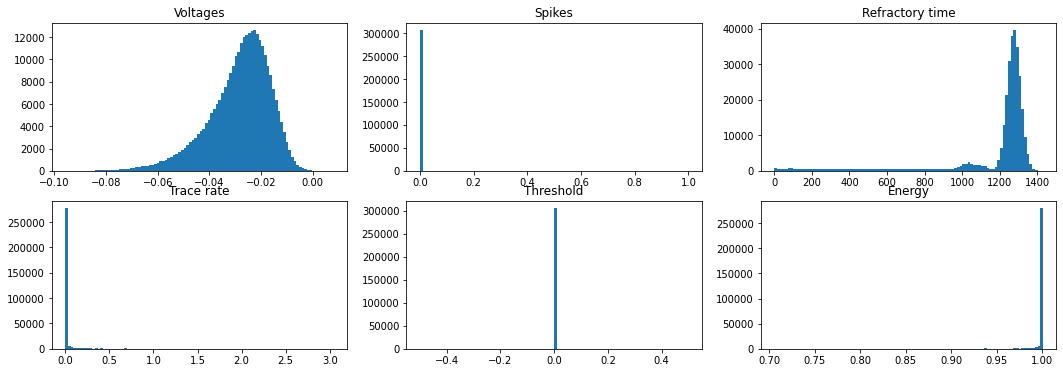

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 6))
axes = axes.flatten()

axes[0].hist(state[0, 1].cpu().numpy().reshape(-1), 100);
axes[0].set_title('Voltages')
axes[1].hist(state[0, 0].cpu().numpy().reshape(-1), 100);
axes[1].set_title('Spikes')
axes[2].hist(state[0, 2].cpu().numpy().reshape(-1), 100);
axes[2].set_title('Refractory time')

axes[3].hist(state[0, 3].cpu().numpy().reshape(-1), 100)
axes[3].set_title('Trace rate')
axes[4].hist(state[0, 4].cpu().numpy().reshape(-1), 100)
axes[4].set_title('Threshold')
axes[5].hist(state[0, 5].cpu().numpy().reshape(-1), 100)
axes[5].set_title('Energy')

(array([ 61509.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 245691.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

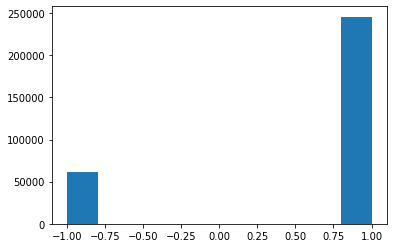

In [12]:
plt.hist(ca.rule.EI.cpu().numpy().reshape(-1))

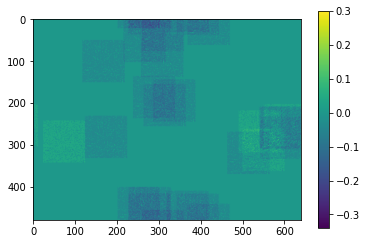

In [13]:
self = ca.rule
x = state

Rk = self.radius
x[:, [0], ...] = x[:, [0], ...] * self.EI
S = F.pad(x[:, [0], ...], (Rk, Rk, Rk, Rk), mode='circular') #spikes
I = F.conv2d(S, self.nearest_neighbours, padding=0)
plt.imshow(I.cpu().numpy()[0, 0].transpose())
plt.colorbar()

In [14]:
fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 60, (RESX, RESY), 1)


for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    out.write(img)
out.release()

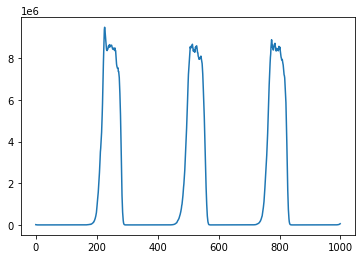

In [16]:
raster = [img.sum() for img in imgs]
plt.plot(raster[0:1000])

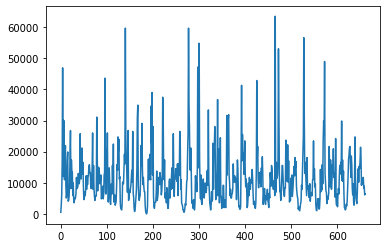

In [17]:
plt.plot(raster[1250:])